In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import scipy.sparse
from scipy.sparse.linalg import spsolve
from utils import *

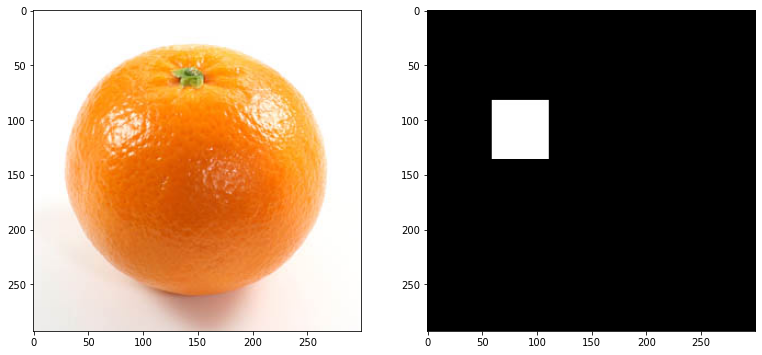

In [2]:
folder_path = "img/archive (1)/"

source = cv2.imread(folder_path + "source_light.jpg")
mask = cv2.imread(folder_path + "mask_light.jpg", cv2.IMREAD_GRAYSCALE) 

#let's plot the image to have a better understanding of the before and after
double_image(source, mask)

In [3]:
def gradient_norm(source, height, width, channels, mask_binary):
    I_x, I_y = finite_forward_gradient_xy(np.log(source))

    I_x, I_y = I_x.reshape((-1, channels)), I_y.reshape((-1, channels))
    I = np.sqrt(I_x ** 2 + I_y ** 2)
    alpha, beta = 0.2 * np.mean(I[mask_binary.flatten() == 1]), 0.2
    
    vx = (np.power(alpha, beta) * np.power(I, -beta) * I_x).reshape((height, width, channels))
    vy = (np.power(alpha, beta) * np.power(I, -beta) * I_y).reshape((height, width, channels))
    
    """ I = [np.gradient(src) for src in source_flat]
    alpha, beta = 0.2 * np.mean(I[mask_binary.flatten() == 1]), 0.2
    
    vx = (np.power(alpha, beta) * np.power(I, -beta) * I).reshape((height, width, channels))"""    
    
    return finite_backward_gradient_xy(vx)[0] + finite_backward_gradient_xy(vy)[1]

In [28]:
#poisson illumination changes
def poisson_illumination_change(source, mask, offset):
    # Calculate image dimensions
    if len(source.shape) == 2:
        height, width = source.shape
        channels = 1
    else:
        height, width, channels = source.shape
    print(f"source: {source.shape}, mask: {mask.shape}")
    
    # Extract and prepare the mask
    mask = mask[:height, :width]
    mask_binary = (mask != 0).astype(np.float32)

    # Create a Laplacian matrix
    laplacian = laplacian_matrix(height, width)

    # Modify the Laplacian matrix for boundary conditions
    for y in range(1, height - 1):
        for x in range(1, width - 1):
            if mask[y, x] == 0:
                k = x + y * width
                laplacian[k, k] = 1
                laplacian[k, k + 1] = 0
                laplacian[k, k - 1] = 0
                laplacian[k, k + width] = 0
                laplacian[k, k - width] = 0

    print("Solving linear system...")
    print(f"laplacian_matrix: {laplacian.shape}")
    # Flatten the source and target images
    source_flat = source.reshape((-1, channels))

    print(f"source: {source.dtype}")
    # Calculate Laplacian of the source image
    #grad_x, grad_y = finite_partial_gradient_xy(np.log(source))
    #laplacian_source = np.sqrt(grad_x**2 + grad_y**2)
    #I = finite_full_gradient_xy(np.log(source)).reshape((-1, channels))
    laplacian_source = gradient_norm(source, height, width, channels, mask_binary)
    #alpha, beta = 0.2 * np.mean(I[mask_binary.flatten() == 1]), 0.2
    
    #v = (np.power(alpha, beta) * np.power(I, -beta) * I).reshape((height, width, channels))
    
    laplacian_source = laplacian_source.reshape((-1, channels)).astype("uint8")

    # Update Laplacian values outside the mask with target values
    laplacian_source[mask_binary.flatten() == 0] = source_flat[mask_binary.flatten() == 0]

    #laplacian_source[mask_binary.flatten() == 1] = np.exp(laplacian_source[mask_binary.flatten() == 1])

    # Solve the linear system to get the blended image 
    laplacian = laplacian.tocsc()
    blended_flat = spsolve(laplacian, laplacian_source)

    # Clip pixel values to the [0, 255] range
    blended_flat = np.clip(blended_flat, 0, 255).astype('uint8')

    # Reshape and update the target image with the blended channel
    target = blended_flat.reshape((height, width, channels))

    return target

cv2.imwrite("illumination_test.png", poisson_illumination_change(source, mask, (0, 0)))

source: (293, 300, 3), mask: (293, 300)
Solving linear system...
laplacian_matrix: (87900, 87900)
source: uint8


C:\Users\leona\AppData\Local\Temp\ipykernel_6580\3744989020.py:2: RuntimeWarning: divide by zero encountered in log
  I_x, I_y = finite_forward_gradient_xy(np.log(source))
C:\Users\leona\AppData\Local\Temp\ipykernel_6580\3866650850.py:44: RuntimeWarning: invalid value encountered in cast
  laplacian_source = laplacian_source.reshape((-1, channels)).astype("uint8")


True

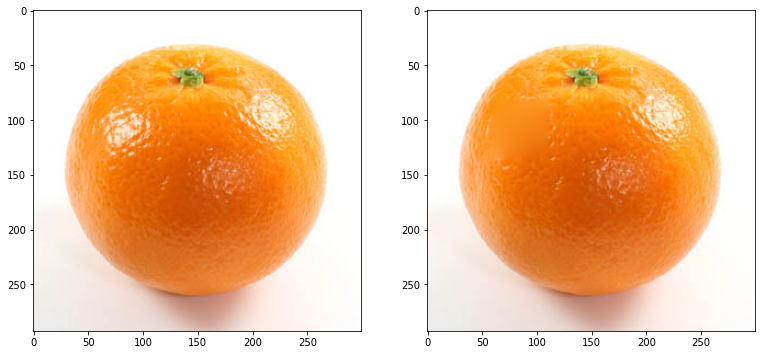

In [29]:
edited = cv2.imread("illumination_test.png")

double_image(source, edited)